#Clasificación de Readmisiones hospitaliarias a pacientes con diabetes
###Realizado por: Estebana Orozco Ramirez
###Para: Ifood


# Descripción del problema

El dataset representa 10 años (1999-2008) de atención clínica en 130 hospitales y redes integradas de prestación de servicios de EE. UU; Y esta asociado al artículo de investigación: *Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records*.(https://downloads.hindawi.com/journals/bmri/2014/781670.pdf)

Mi objetivo, es analizar qué factores están relacionados con los reingresos y estudiar las demás características asociadas a los pacientes para lograr una clasificación que relacione los pacientes y los hospitales.

##Puntos claves del paper

Después de leer el artículo asociado al dataset, identifico los siguientes puntos clave:

- Se utilizó una regresión logística multivariable para conocer la relación entre la medición de la HbA1c y el reingreso precoz, controlando al mismo tiempo covariables como los datos demográficos, la gravedad y el tipo de enfermedad, y el tipo de ingreso.

- La medición de la HbA1c se realizó con poca frecuencia (18,4%) en el ámbito hospitalario.

- El modelo estadístico sugiere que la relación entre la probabilidad de reingreso y la medición de la HbA1c depende del diagnóstico primario.

- Los datos sugieren además que una mayor atención a la diabetes, reflejada en la medición de la HbA1c, puede mejorar los resultados de los pacientes y reducir el coste de la atención hospitalaria.

- Las bases de datos clínicos contienen datos valiosos pero heterogéneos y difíciles en términos de valores perdidos, registros incompletos o inconsistentes, y una alta dimensionalidad entendida no sólo por el número de características sino también por su complejidad.

- Se realizó un análisis preliminar y un preprocesamiento de los datos que dio como resultado que se retuvieran sólo aquellas características (atributos) y encuentros que pudieran ser utilizados en el análisis posterior, es decir, que contuvieran suficiente información.

##Información conocida del Dataset
Se extrajo información de la base de datos para los ingresos que cumplieron con los siguientes criterios.
- Es un ingreso hospitalario (una admisión hospitalaria).
- Es un ingreso diabético, es decir, durante el cual se ingresó al sistema cualquier tipo de diabetes como diagnóstico.
- La duración de la estancia fue de al menos 1 día y como máximo 14 días.
- Se realizaron pruebas de laboratorio durante la estancia.
- Se administraron medicamentos durante la estancia.

Los datos contienen atributos tales como número de paciente, raza, sexo, edad, tipo de admisión, tiempo en el hospital, especialidad médica del médico que lo admite, número de pruebas de laboratorio realizadas, resultado de la prueba de HbA1c, diagnóstico, cantidad de medicación, medicamentos para diabéticos, cantidad de pacientes ambulatorios , visitas hospitalarias y urgentes en el año anterior a la hospitalización, etc. Para cada registro existe uno de los siguientes resultados:

1. No readmisión;

2. Readmisión en menos de 30 días (esta situación no es buena, porque existe la posibilidad de que el tratamiento aplicado no fue apropiado);

3. Readmisión después de 30 días (esta situación tampoco es buena, sin embargo, la razón podría estar relacionada con el estado del paciente).

###Descripción de los datos 
https://www.hindawi.com/journals/bmri/2014/781670/tab1/

# Limpieza de los Datos

##Importar Librerías

In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import plotly.express as px


##Cargar Dataset

In [2]:
data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/diabetic_data.csv")

In [3]:
data_raw.head(10)

encounter_id  patient_nbr             race  ... change diabetesMed readmitted
0       2278392      8222157        Caucasian  ...     No          No         NO
1        149190     55629189        Caucasian  ...     Ch         Yes        >30
2         64410     86047875  AfricanAmerican  ...     No         Yes         NO
3        500364     82442376        Caucasian  ...     Ch         Yes         NO
4         16680     42519267        Caucasian  ...     Ch         Yes         NO
5         35754     82637451        Caucasian  ...     No         Yes        >30
6         55842     84259809        Caucasian  ...     Ch         Yes         NO
7         63768    114882984        Caucasian  ...     No         Yes        >30
8         12522     48330783        Caucasian  ...     Ch         Yes         NO
9         15738     63555939        Caucasian  ...     Ch         Yes         NO

[10 rows x 50 columns]

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

##Remover duplicados e información innecesaria

El campo ***patient_nbr*** es un identicador único del paciente, por lo que no deberían existir dos iguales en los datos, esto sesgaría el algoritmo que se vaya a implementar. Se realiza una suma de los duplicados en esta columna para saber cuántos son y luego se eliminan conservando solo la última ocurrencia/aparición del paciente en los registros.

In [5]:
data_raw["patient_nbr"].duplicated().sum()

30248

In [6]:
'''
Ordeno el dataset por el identificador de paciente
y luego por por el ID de llegada (encounter_id), asumiendo 
que este último se asigna de manera consecutiva según 
el orden de llegada. 
Esto me va a permitir dejar solo los registros que 
correspondan a la última visita del paciente.
'''
data_raw.sort_values(by=["patient_nbr", 'encounter_id'], inplace=True)

In [7]:
data_raw.drop_duplicates(subset ="patient_nbr", keep = "last", inplace = True)

Después de eliminar los duplicados, estas columnas de identificación no son de valor para un modelo de clasificación, así que las elimino

In [8]:
data_raw.drop(['encounter_id','patient_nbr'],axis=1,inplace=True)

In [9]:
'''
Realizo nuevamente la validación de los duplicados
para asegurarme de que el código funcionó
'''
print(f"Datos duplicados = {len(data_raw)-len(data_raw.drop_duplicates())}")

Datos duplicados = 0


La columna ***discharge_disposition_id*** permite conocer qué pasa con un paciente cuándo sale del hospital y a dónde va. Pensando en un modelo que estudie el comportamiento de las readmisiones, no son de valor para mí los siguientes registros:
- 11 = Fallecido
- 13 = Desahuciado / Casa
- 14 = Desahuciado / Centro Médico
- 19 = Fallecido en casa. Subsidiado por Medicaid, desahuciado.
- 20 = Fallecido en un centro médito. Subsidiado por Medicaid, desahuciado. 
- 21 = Fallecido en un lugar desconocido. Subsidiado por Medicaid, desahuciado.

Alguien que fallece o queda desahuciado no va a volver a un centro médico, por lo que tomo la decisión de borrarlos

In [10]:
data_raw = data_raw[~data_raw["discharge_disposition_id"].isin([11,13,14,19,20])]

In [11]:
data_raw.shape

(69169, 48)

##Tratamiento de valores perdidos

In [12]:
#Reviso algunas muestras aleatorias de los datos
data_raw.sample(10).T

51347  ...             9232 
race                       AfricanAmerican  ...         Caucasian
gender                                Male  ...            Female
age                                [50-60)  ...           [50-60)
weight                                   ?  ...                 ?
admission_type_id                        1  ...                 1
discharge_disposition_id                 1  ...                 1
admission_source_id                      7  ...                 7
time_in_hospital                         5  ...                 2
payer_code                               ?  ...                 ?
medical_specialty         InternalMedicine  ...  InternalMedicine
num_lab_procedures                      95  ...                55
num_procedures                           0  ...                 0
num_medications                         25  ...                 8
number_outpatient                        0  ...                 0
number_emergency                         0  ...                 0
number_inpatient                         0  ...                 1
diag_1                                 486  ...               401
diag_2                                 427  ...            250.01
diag_3                                 276  ...               786
number_diagnoses                         9  ...                 8
max_glu_serum                         None  ...              None
A1Cresult                               >7  ...              None
metformin                           Steady  ...            Steady
repaglinide                             No  ...                No
nateglinide                             No  ...                No
chlorpropamide                          No  ...                No
glimepiride                             No  ...                No
acetohexamide                           No  ...                No
glipizide                               No  ...                No
glyburide                               No  ...                No
tolbutamide                             No  ...                No
pioglitazone                            No  ...                No
rosiglitazone                           No  ...                No
acarbose                                No  ...                No
miglitol                                No  ...                No
troglitazone                            No  ...                No
tolazamide                              No  ...                No
examide                                 No  ...                No
citoglipton                             No  ...                No
insulin                             Steady  ...                No
glyburide-metformin                     No  ...                No
glipizide-metformin                     No  ...                No
glimepiride-pioglitazone                No  ...                No
metformin-rosiglitazone                 No  ...                No
metformin-pioglitazone                  No  ...                No
change                                  Ch  ...                No
diabetesMed                            Yes  ...               Yes
readmitted                              NO  ...                NO

[48 rows x 10 columns]

Existen registros con el carácter '?' en sus columnas, lo que quiere decir que así llenaron los valores perdidos en el dataset. 
Por medio del metodo unique reviso cuáles son los valores únicos de cada columna:

In [13]:
for col in data_raw:
    print(f"{col} = {data_raw[col].unique()}")

race = ['Caucasian' 'AfricanAmerican' 'Hispanic' '?' 'Asian' 'Other']
gender = ['Female' 'Male' 'Unknown/Invalid']
age = ['[50-60)' '[80-90)' '[30-40)' '[60-70)' '[40-50)' '[70-80)' '[10-20)'
 '[90-100)' '[20-30)' '[0-10)']
weight = ['?' '[50-75)' '[25-50)' '[75-100)' '[100-125)' '[125-150)' '[0-25)'
 '[175-200)' '[150-175)' '>200']
admission_type_id = [1 3 2 6 8 4 5 7]
discharge_disposition_id = [ 1  3  6  5  4  2 25 22 18  7  8 23 15 12 28 27 17 16 24  9 10]
admission_source_id = [ 7  1  4  6  5 17  2  3 20  9  8 14 10 11 22 13 25]
time_in_hospital = [ 3  2  4  5 12  9 14  8  1  7  6 13 10 11]
payer_code = ['?' 'MC' 'BC' 'UN' 'MD' 'HM' 'CP' 'DM' 'PO' 'SP' 'CM' 'OT' 'SI' 'WC' 'MP'
 'CH' 'OG' 'FR']
medical_specialty = ['Surgery-Cardiovascular/Thoracic' 'Surgery-Neuro' 'InternalMedicine'
 'Hematology/Oncology' 'Cardiology' '?' 'Orthopedics-Reconstructive'
 'Surgery-General' 'Emergency/Trauma' 'Nephrology'
 'Family/GeneralPractice' 'Psychiatry' 'Orthopedics'
 'ObstetricsandGynecology' 'P

**Análisis**

- Las columnas *race , weight, payer_code, medical_speciality, diag_2* tienen el valor '?' .
- *gender* contiene el texto 'Unknown/Invalid'.

- Estas columnas de medicamentos tienen el mismo valor siempre:

    - examide = ['No']
    - citoglipton = ['No']
    - glimepiride-pioglitazone  = ['No']

Por lo que no proveén información para el clasificador.

In [14]:
# Elimino las columnas examide, citoglipton, glimepiride-pioglitazone
data_raw.drop(['examide','citoglipton','glimepiride-pioglitazone'],axis=1,inplace=True)

In [15]:
data_raw[data_raw["gender"] == 'Unknown/Invalid'].shape

(3, 45)

Solo hay 3 filas que tienen el valor de 'Unknown/Invalid' en el género, por lo que decido borrarlas

In [16]:
data_raw.drop(data_raw[data_raw["gender"] == 'Unknown/Invalid'].index, inplace=True)
print(f"cantidad de valores únicos en gender = {data_raw['gender'].nunique()}")

cantidad de valores únicos en gender = 2


Reemplazo el signo '?' por NA, para que sean nulos de verdad

In [17]:
data_raw.replace('?',np.nan,inplace=True)

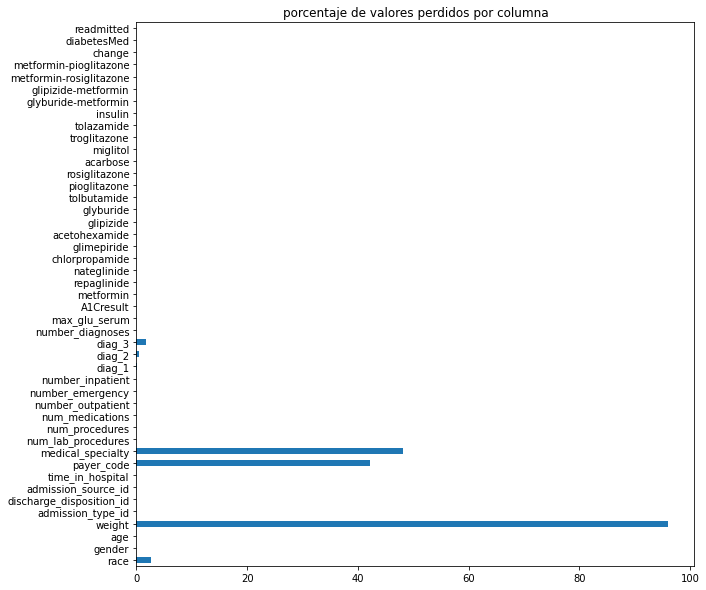

In [18]:
''' 
Calculo del porcentaje de valores perdidos por columna
''' 
(data_raw.isnull().sum()*100/len(data_raw)).plot(kind="barh",figsize=(10,10),title = 'porcentaje de valores perdidos por columna')

In [19]:
missing = data_raw.isnull().sum()
missing[missing>0]*100/len(data_raw)

race                  2.660267
weight               95.987913
payer_code           42.264986
medical_specialty    48.068415
diag_1                0.023133
diag_2                0.416390
diag_3                1.651100
dtype: float64

Elimino la columna Weight porque tiene el 95% de los datos vacíos.
La columna de payer_code además de tener el 45% de los datos nulos, no debería ser de mucho interés para el análisis; ya que según la ética médica la atención o remisiones no deberían verse afectadas por quién o cómo se pago la cuenta. Por lo anterior la elimino también.

In [20]:
data_raw.drop(['weight','payer_code'],axis=1,inplace=True)

Análisis de ***medical_specialty***

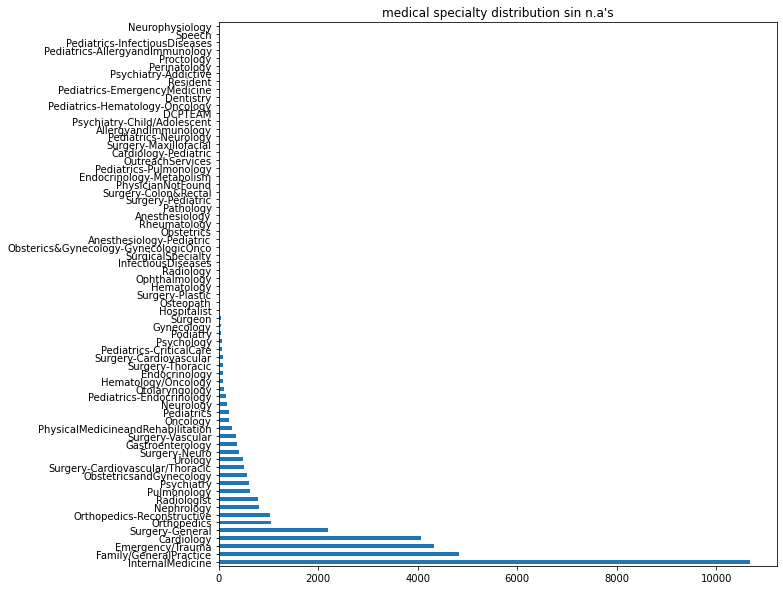

In [21]:
bar = data_raw["medical_specialty"].value_counts()
bar.plot(kind="barh",figsize=(10,10),title="medical specialty distribution sin n.a's")

Para esta columna prefiero hacer una revisión estadística antes de tomar alguna decisión. Así que temporalmente reemplazo los NA por 'Unknow'

In [22]:
data_raw["medical_specialty"].fillna('Unknow', inplace=True)

Análisis de ***race***

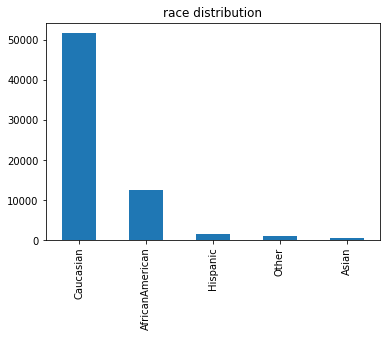

In [23]:
bar = data_raw["race"].value_counts()
bar.plot.bar(title="race distribution")

In [24]:
data_raw["race"].isnull().sum()

1840

Teniendo en cuenta que los datos vacíos son solo el 3% decido reemplazar los valores NA por la moda, es decir, *caucasian*.

In [25]:
data_raw["race"].fillna(data_raw['race'].mode()[0], inplace=True)

In [26]:
#
print(f"Duplicated data = {len(data_raw)-len(data_raw.drop_duplicates())}")

Duplicated data = 0


In [27]:
data_raw.isnull().sum()

race                           0
gender                         0
age                            0
admission_type_id              0
discharge_disposition_id       0
admission_source_id            0
time_in_hospital               0
medical_specialty              0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                        16
diag_2                       288
diag_3                      1142
number_diagnoses               0
max_glu_serum                  0
A1Cresult                      0
metformin                      0
repaglinide                    0
nateglinide                    0
chlorpropamide                 0
glimepiride                    0
acetohexamide                  0
glipizide                      0
glyburide                      0
tolbutamide                    0
pioglitazone                   0
rosiglitaz

Análisis **Diagnosticos**  
Los diagnosticos se dan en orden y dependiendo de las necesidades del paciente, por lo que es normal tener valores vacíos en *diag_3* cuando no hay valor en *diag_2*. No es común que pase lo contrario, es decir, tener valores en *diag_3* y no en *diag_2*.  
Por último, algo inadmisible es no tener valores en *diag_1*.

In [28]:
data_raw.dropna(subset=["diag_1"], inplace = True)

In [29]:
'''
Cantidad de registros en los que tanto diag_2
como diag_3 son nulos 
'''
data_raw["diag_3"].loc[data_raw["diag_2"].isnull()].isnull().sum()

240

In [30]:
'''
Si diag_2 es nulo y diag_3 tiene valor, 
se copian los datos de diag_3 a diag_2
'''
data_raw["diag_2"].loc[data_raw["diag_2"].isnull()] = data_raw["diag_3"].loc[data_raw["diag_2"].isnull()].copy()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
''' Sí el diagnostico secundario (diag_2) es nulo
se llena con  el diagnostico primario (diag_1).
'''

data_raw["diag_2"].loc[data_raw["diag_2"].isnull()] = data_raw["diag_1"].loc[data_raw["diag_2"].isnull()].copy()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
'''
Sí diag_3 esta vacío se llena con el
valor del diag_2 
'''
data_raw["diag_3"].loc[data_raw["diag_3"].isnull()] = data_raw["diag_2"].loc[data_raw["diag_3"].isnull()].copy()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
# reinicio los index del data frame, para evitar errores por los reemplazos hechos con las copias
data_raw.reset_index(inplace=True, drop=True)

In [34]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69150 entries, 0 to 69149
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      69150 non-null  object
 1   gender                    69150 non-null  object
 2   age                       69150 non-null  object
 3   admission_type_id         69150 non-null  int64 
 4   discharge_disposition_id  69150 non-null  int64 
 5   admission_source_id       69150 non-null  int64 
 6   time_in_hospital          69150 non-null  int64 
 7   medical_specialty         69150 non-null  object
 8   num_lab_procedures        69150 non-null  int64 
 9   num_procedures            69150 non-null  int64 
 10  num_medications           69150 non-null  int64 
 11  number_outpatient         69150 non-null  int64 
 12  number_emergency          69150 non-null  int64 
 13  number_inpatient          69150 non-null  int64 
 14  diag_1                

In [35]:
# Total de valores perdidos en el Dataset

print(f"Total de valores perdidos en el Dataset = {data_raw.isnull().sum().sum()}")

Total de valores perdidos en el Dataset = 0


**RESULTADOS PARCIALES**  
Datos sin procesar:  
- 101766 filas, 50 columnas y 38.8 MB de espacio en memoria  

Después de la limpieza:    
- 69150 filas, 43 columnas y 22.7 MB de espacio en memoria

# Análisis Exploratorio

In [36]:
'''En este punto creo un nuevo DataFrame con los trasnformaciones realizadas hasta este punto, "check-point" '''
diabetic_df = data_raw.copy()
diabetic_df.shape

(69150, 43)

## Correccion del tipo de dato de cada columna (optimizar memoria)

In [37]:
'''
Es importante convertir las columnas de ID
númericos que representan una categoría a
categoricas
'''
diabetic_df["admission_type_id"] = diabetic_df["admission_type_id"].astype('category')
diabetic_df["discharge_disposition_id"] = diabetic_df["discharge_disposition_id"].astype('category')
diabetic_df["admission_source_id"] = diabetic_df["admission_source_id"].astype('category')

## Perfilamiento de datos
Para agilizar el análisis utilizo la herramienta de pandas-profilling (https://pandas-profiling.github.io/pandas-profiling/docs/master/index.html) para perfilar los datos e identificar características claves de cada columna


In [38]:
# Se importa la librería y se crea el reporte
from pandas_profiling import ProfileReport
profile = ProfileReport(diabetic_df, title='Perfilamiento_DatasetDiabetes',
                        explorative=True, samples=None, correlations=None, 
                        missing_diagrams=None, duplicates=None, interactions=None)
profile.to_notebook_iframe()

#Se guarda el reporte realizado con pandas profilling
profile.to_file("/content/drive/MyDrive/Colab Notebooks/Perfilamiento_DatasetDiabetes.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Conclusiones después del perfilamiento

1. Se tienen problemas de cardinalidad en las columnas:  
    - diag_1: 691 valores distintos, 414 (7.7%) es el valor más común.
    - diag_2: 716 valores distintos, 250 (7.7%) es el valor más común.
    - diag_3: 745 valores distintos.
    - medical_specialty: 70 valores distintos.
2. Existen muchos valores con cero en las columnas:
    - num_procedures tiene 30820 (44,6%) ceros. 
    - number_outpatient tiene 59051 (85,4%) ceros 
    - number_emergency tiene 62982 (91,1%) ceros 
    - number_inpatient tiene 50339 (72,8%) ceros 
3. La columna number_emergency está muy sesgada hacia la derecha debido a sus 62982 valores en cero.
4. La distribución de la variable de salida (Readmitted) es:  
 75% No , >30 20%, <30 4.6%



## Corrección cardinalidad


1. Para arreglar la cardinalidad de los valores en los campos de diagnostico, utilizo los valores de la [Tabla 2](https://www.hindawi.com/journals/bmri/2014/781670/tab2/), presente en el artículo de referencia, para definir categorías.

In [39]:
#Primero limpio un poco los datos
diag_cols = ['diag_1','diag_2','diag_3']
df_copy = diabetic_df[diag_cols].copy()
for col in diag_cols:
    df_copy[col] = df_copy[col].str.replace('E','-')
    df_copy[col] = df_copy[col].str.replace('V','-')
    condition = df_copy[col].str.contains('250')
    df_copy.loc[condition,col] = '250'

df_copy[diag_cols] = df_copy[diag_cols].astype(float)

In [40]:
df_copy.sample(10).T

36690  29575  31698  39574  33295  4087   46305  36654  32418  37687
diag_1  414.0  305.0  250.0  414.0  493.0  250.0  -71.0  410.0  507.0  427.0
diag_2  411.0  305.0  295.0  413.0  250.0  403.0  401.0  428.0  428.0  427.0
diag_3  396.0  276.0  401.0  496.0  -10.0  996.0  250.0  157.0  250.0  585.0

In [41]:
df_copy[diag_cols] = df_copy[diag_cols].astype(float)
for col in diag_cols:
    df_copy['temp']=np.nan
    
    condition = (df_copy[col]>=390) & (df_copy[col]<=459) | (df_copy[col]==785)
    df_copy.loc[condition,'temp']='Circulatory'
    
    condition = (df_copy[col]>=460) & (df_copy[col]<=519) | (df_copy[col]==786)
    df_copy.loc[condition,'temp']='Respiratory'
    
    condition = (df_copy[col]>=520) & (df_copy[col]<=579) | (df_copy[col]==787)
    df_copy.loc[condition,'temp']='Digestive'

    condition = (df_copy[col]>=800) & (df_copy[col]<=999)
    df_copy.loc[condition,'temp']='Injury'

    condition = (df_copy[col]>=710) & (df_copy[col]<=739)
    df_copy.loc[condition,'temp']='Muscoloskeletal'
    
    condition = (df_copy[col]>=580) & (df_copy[col]<=629) | (df_copy[col]==788)
    df_copy.loc[condition,'temp']='Genitourinary'    
     
    condition = (df_copy[col]>=140) & (df_copy[col]<=239) | (df_copy[col]==780)
    df_copy.loc[condition,'temp']='Neoplasms'

    condition = (df_copy[col]>=240) & (df_copy[col]<=279) | (df_copy[col]==781)
    df_copy.loc[condition,'temp']='Neoplasms'

    condition = (df_copy[col]>=680) & (df_copy[col]<=709) | (df_copy[col]==782)
    df_copy.loc[condition,'temp']='Neoplasms'

    condition = (df_copy[col]>=790) & (df_copy[col]<=799) | (df_copy[col]==784)
    df_copy.loc[condition,'temp']='Neoplasms'
    
    condition = (df_copy[col]>=1) & (df_copy[col]<=139)
    df_copy.loc[condition,'temp']='Neoplasms'

    condition = (df_copy[col]>=290) & (df_copy[col]<=319)
    df_copy.loc[condition,'temp']='Neoplasms'

    condition = (df_copy[col]==250)
    df_copy.loc[condition,'temp']='Diabetes'
    
    df_copy['temp']=df_copy['temp'].fillna('Others')
    condition = df_copy['temp']=='0'
    df_copy.loc[condition,'temp']=np.nan
    df_copy[col]=df_copy['temp']
    df_copy.drop('temp',axis=1,inplace=True)

In [42]:
#Reemplazo los valores en las columnas por las categorías
diabetic_df[diag_cols] = df_copy.copy()
del df_copy
# Cantidad de valores únicos en las columnas de diagnostico
diabetic_df[diag_cols].describe().loc['unique']

diag_1    9
diag_2    9
diag_3    9
Name: unique, dtype: object

2. Para arreglar la cardinalidad de los valores en la columna de ***medical_specialty*** evalúo el top n de especialidades de acuerdo a la frecuencia, y asigno las que no están en este el valor 'others'.

In [43]:
umbral = diabetic_df['medical_specialty'].value_counts(normalize=True)
print(umbral)

Unknow                    0.480694
InternalMedicine          0.154346
Family/GeneralPractice    0.069920
Emergency/Trauma          0.062458
Cardiology                0.058843
                            ...   
Proctology                0.000014
Perinatology              0.000014
Speech                    0.000014
Resident                  0.000014
Psychiatry-Addictive      0.000014
Name: medical_specialty, Length: 70, dtype: float64


In [44]:
#Me quedo sólo con las especialidades que tengan al menos más del 1% de participación
top = umbral[umbral > 0.01]
print(f'Número de espcialidades en el top = {len(top)}')

Número de espcialidades en el top = 10


In [45]:
# Cambio los demás valores por Other 
diabetic_df.loc[~diabetic_df['medical_specialty'].isin(list(top.index)),'medical_specialty']='Other'

In [46]:
diabetic_df["medical_specialty"].unique()

array(['Other', 'InternalMedicine', 'Cardiology', 'Unknow',
       'Orthopedics-Reconstructive', 'Surgery-General',
       'Emergency/Trauma', 'Nephrology', 'Family/GeneralPractice',
       'Orthopedics', 'Radiologist'], dtype=object)

## Feature Engineering

**Prueba de glucosa en suero**  
Se utiliza una prueba de glucosa en sangre para determinar si los niveles de azúcar en sangre se encuentran dentro del rango saludable. A menudo, para ayudar a diagnosticar y controlar la diabetes.

Valores para la columna ***max_glu_serum***  
- '> 200': = indica diabetes  
- '> 300': = indica diabetes  
- 'Norm': = Normal   
- 'None': = No se tomó la prueba  

Estos valores se reemplazarán por valores numéricos para facilitar el análisis, teniendo en cuenta que nuestro interés principal está en quienes tienen diabetes.


In [47]:
diabetic_df["max_glu_serum"].replace({'>200':1 ,'>300':1 ,'Norm':0 ,'None':-99}, inplace=True)

De la misma forma codifico la prueba A1C

In [48]:
diabetic_df["A1Cresult"].replace({'>7':1 ,'>8':1 ,'Norm':0 ,'None':-99}, inplace=True)

Codifico las categorías binomiales, para que sean 1 ó 0.

In [49]:
diabetic_df['change'].replace('Ch', 1, inplace=True)
diabetic_df['change'].replace('No', 0, inplace=True)
diabetic_df['gender'].replace('Male', 1, inplace=True)
diabetic_df['gender'].replace('Female', 0, inplace=True)
diabetic_df['diabetesMed'].replace('Yes', 1, inplace=True)
diabetic_df['diabetesMed'].replace('No', 0, inplace=True)

**Medicinas**  
Se tienen 24 colmunas con información relativa a los medicamentos sumistrados al paciente.   
El objetivo de estos campos es describir el comportamiento en el tiempo de las medicinas así:  
- albergan el valor “up” si la dosis se aumentó durante la visita al hospital, “down” si la dosis se redujo, “steady” si la dosis no cambió, y “no” si el medicamento no se prescribió.

Para dar más valor a mis datos, voy a agrupar toda esta información en una columna que indique cuántos cambios de medicina se han hecho en total para un paciente.

In [50]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 
        'acetohexamide', 'tolbutamide', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin',
        'glipizide-metformin', 'metformin-rosiglitazone', 'metformin-pioglitazone']


In [51]:
for col in keys:
    colname = str(col) + 'temp'
    diabetic_df[colname] = diabetic_df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
diabetic_df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    diabetic_df['numchange'] = diabetic_df['numchange'] + diabetic_df[colname]
    del diabetic_df[colname]
    
diabetic_df['numchange'].value_counts()

0    51832
1    16355
2      883
3       77
4        3
Name: numchange, dtype: int64

Ahora que tengo mi nueva columna, procedo a codificar los valores en cada una de las medicinas, para que sean numericos y no textos

In [52]:
for col in keys:
    diabetic_df[col].replace({'No': 0,'Steady': 1 , 'Up':1, 'Down': 1},inplace=True)   

**Variable de Salida**

Por medio de la salida de este dataset, se pretende responder qué tan efectivo fue el tratamiento dado por el hospital al paciente. Tenido esto en cuenta:
- Una re-admisión menor a 30 días no es buena, porque quizás el tratamiento no fue el adecuado.
- Una re-admisión mayor a 30 días tampoco es buena, pero es más llevadera porque puede deberse al estado del paciente.

Como mi objetivo es clasificar los pacientes con una re-dmisión menor a 30 días, agrupo la información de la re-admisión mayor a 30 días con la de aquellos pacientes que no fueron re-admitidos

In [53]:
diabetic_df["readmitted"].replace({'<30':1, '>30':0, 'NO':0}, inplace=True)
diabetic_df["readmitted"].value_counts()

0    65955
1     3195
Name: readmitted, dtype: int64

Es inmediatamente visible que nuestra columna objetivo se encuentra desbalanceada, por lo que se debe transformar antes de implementar un modelo o tener mucho cuidado a la hora de elegir las medidas para evaluar la eficacia del modelo.


In [54]:
diabetic_df.duplicated().sum()

1

In [55]:
diabetic_df.drop_duplicates(keep=False,inplace=True, ignore_index=True) 

## Análisis Bivariable

In [ ]:
!pip install pywedge
import pywedge as pw

In [57]:
mc = pw.Pywedge_Charts(diabetic_df, c=None, y="readmitted" )
# For Visualization
chart = mc.make_charts()

HTML(value='<h2>Pywedge Make_Charts </h2>')

In [67]:
newdf = diabetic_df.select_dtypes(include=['int64'])
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69148 entries, 0 to 69147
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   gender                   69148 non-null  int64
 1   time_in_hospital         69148 non-null  int64
 2   num_lab_procedures       69148 non-null  int64
 3   num_procedures           69148 non-null  int64
 4   num_medications          69148 non-null  int64
 5   number_outpatient        69148 non-null  int64
 6   number_emergency         69148 non-null  int64
 7   number_inpatient         69148 non-null  int64
 8   number_diagnoses         69148 non-null  int64
 9   max_glu_serum            69148 non-null  int64
 10  A1Cresult                69148 non-null  int64
 11  metformin                69148 non-null  int64
 12  repaglinide              69148 non-null  int64
 13  nateglinide              69148 non-null  int64
 14  chlorpropamide           69148 non-null  int64
 15  gl

In [68]:
newdf_corr = newdf.corr()
px.imshow(newdf_corr,  width=800, height=800)


In [69]:
diabetic_df.drop(['change','diabetesMed','num_medications'],axis=1,inplace=True)

# Modelamiento de datos

In [70]:
data = diabetic_df.copy()
data.shape

(69148, 42)

In [71]:
data.describe()

gender  time_in_hospital  ...    readmitted     numchange
count  69148.000000      69148.000000  ...  69148.000000  69148.000000
mean       0.467765          4.291201  ...      0.046205      0.265575
std        0.498963          2.955702  ...      0.209931      0.477273
min        0.000000          1.000000  ...      0.000000      0.000000
25%        0.000000          2.000000  ...      0.000000      0.000000
50%        0.000000          3.000000  ...      0.000000      0.000000
75%        1.000000          6.000000  ...      0.000000      1.000000
max        1.000000         14.000000  ...      1.000000      4.000000

[8 rows x 33 columns]

In [72]:
cat_cols = list(data.select_dtypes('object').columns)
class_dict = {}
for col in cat_cols:
    data = pd.concat([data.drop(col, axis=1), pd.get_dummies(data[col], prefix=col, drop_first=True)], axis=1)

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69148 entries, 0 to 69147
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   gender                                        69148 non-null  int64   
 1   admission_type_id                             69148 non-null  category
 2   discharge_disposition_id                      69148 non-null  category
 3   admission_source_id                           69148 non-null  category
 4   time_in_hospital                              69148 non-null  int64   
 5   num_lab_procedures                            69148 non-null  int64   
 6   num_procedures                                69148 non-null  int64   
 7   num_medications                               69148 non-null  int64   
 8   number_outpatient                             69148 non-null  int64   
 9   number_emergency                              6914

## Datos de entrada y de salida

In [74]:
X = data.drop("readmitted", axis=1)
y= data["readmitted"]

## 70/30 Estratificado
Divido los datos en un 70% para entrenamiento y un 30% para test, además lo hago de forma estratificada debido al desbalance de los datos

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state =123, stratify=y)
perc_test = y_test.value_counts()[1]*100/len(y_test)
perc_train = y_train.value_counts()[1]*100/len(y_train)

print(f" Porcentaje de valores tipo 1 en: test set ={perc_test} , train set={perc_train}")

 Porcentaje de valores tipo 1 en: test set =4.622800674861413 , train set=4.619548375100717


## Datos balanceados
Después de una revisión bibliografica sobre los modelos de clasificación en este dataset, encontré artículos en los que se explica por qué la mejor forma de balancear estos datos es el método SMOTE, por lo que decido usarlo para transformar los datos de entrenamiento

In [76]:
## Datos balanceados
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Selección de las medidas
La métrica de evaluación seleccionada es la

**Recall - Sensitivity**

Un Falso Negativo puede retrasar/evitar nuevas pruebas o tratamientos, sin embargo un Falso Positivo puede simplemente llevar a más pruebas o tratamientos, por lo que no es tan costoso como poner una vida en juego.

In [77]:
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Selected algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

## Selección del modelo

In [78]:
seed =2
models = []
#logistic Regression
models.append(('LR', LogisticRegression(solver='liblinear')))

# Decision Tree classifier
models.append(('CART', DecisionTreeClassifier()))

# Naïve Bayes
models.append(('NB', GaussianNB()))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'
for name, model in models:
	# Kfol cross validation for model selection
	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
	#X train , y train
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = f"({name}, {cv_results.mean()}, {cv_results.std()}"
	print(msg)

(LR, 0.02440540073536938, 0.0026132257654197743
(CART, 0.9556355568517338, 0.003266150341609465
(NB, 0.02440540073536938, 0.0026132257654197743


## Hyper Parameter optimization

In [79]:
from sklearn.model_selection import GridSearchCV

In [80]:
y.value_counts()/len(y)

0    0.953795
1    0.046205
Name: readmitted, dtype: float64

In [82]:
parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'criterion': 'gini', 'max_depth': 150}

In [83]:
grid_search.best_score_

0.9382786120996194

In [84]:
CART_best = grid_search.best_estimator_

## Evaluación final en el dataset de pruebas

In [85]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [86]:
CART_best.fit(X_train,y_train)
y_pred = CART_best.predict(X_test)

In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     19786
           1       0.07      0.12      0.09       959

    accuracy                           0.89     20745
   macro avg       0.51      0.52      0.52     20745
weighted avg       0.92      0.89      0.90     20745



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



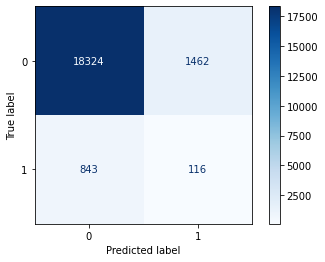

In [88]:
plot_confusion_matrix(CART_best, X_test, y_test,cmap=plt.cm.Blues); 

In [89]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp+fn)
sensitivity

0.12095933263816476